In [63]:
push!(LOAD_PATH, ".");

In [2]:
using FoodWebs
using Distributions
using Gadfly

Now when I want to look at the stability checkmarks for a given combination of random network topology and IS distribution I need to think about the different ways that I can

In [49]:
"This samples an increasing mean IS community matrix for a single random food web network"
function sample(nsample::Int, f::Float64)
    deigs = zeros(nsample)
    rvals = linspace(0.0, 8.0, nsample)
    web = may_network(250, 0.25) # for generality I would likely want this to be passed in
    for i in 1:nsample
        cmat = random_predprey(web, Uniform(rvals[i], rvals[i] + 1.0), f)
        deigs[i] = maximum(real(eigvals(cmat)))
    end
    hcat(rvals, deigs)
end

sample (generic function with 1 method)

When looking at some of the above code I realize I don't really know what the performance implications are for using an iterator in place of just a collected array is. My feeling from looking at the `sample` code is that I and accessing the iterator twice, once in the inner loop and next when I use `hcat` so if accessing an iterator is slower than indexing a array then I will have a speed penalty, though it might be slight.

What I would like to do is see if I can find out from some micro benchmarks.

In [9]:
test = linspace(0.0, 8.0, 10000);
ctest = collect(test);

In [23]:
@time for i = 1:10000 test[i] end

  0.000203 seconds (19.49 k allocations: 304.516 KB)


In [26]:
@time for i = 1:10000 ctest[i] end

  0.000179 seconds (19.49 k allocations: 304.516 KB)


So it seems marginally faster at best. This is nice.

So What I want to test is the speed of this code for doing a proper generation of a "checkmark" stability pattern. To do this I need to actually take averages of each run for a given network so that I remove some of the variation that occurs from the different draws of the random network structure.

In [64]:
@time samples = [sample(100, 0.8) for i = 1:10];

In [68]:
Profile.clear()
@profile sample(100, 0.8)
Profile.print(format=:flat)

 Count File                       Function                                 Line
     2 ...e\continuous\uniform.jl rand                                       75
  4681 ....4\IJulia\src\IJulia.jl eventloop                                 141
  4681 ...\src\execute_request.jl execute_request_0x535c5df2                177
     3 ...Julia Ideas\FoodWebs.jl random_predprey                            55
    10 ...Julia Ideas\FoodWebs.jl random_predprey                            57
     3 ...Julia Ideas\FoodWebs.jl random_predprey                            58
     1 ...Julia Ideas\FoodWebs.jl random_predprey                            59
    17 In[49]                     sample                                      7
  4664 In[49]                     sample                                      8
     4 array.jl                   copy                                      101
     3 array.jl                   fill!                                     193
  4660 linalg/eigen.jl            eigval

So `samples` is an Array of n x 2 Arrays that contain each individual checkmark for a given network structure. What I want to do now is take the mean of all this runs.

In [69]:
@time mean_data = mean(hcat([s[:, 2] for s in samples]));

  0.000051 seconds (71 allocations: 19.016 KB)


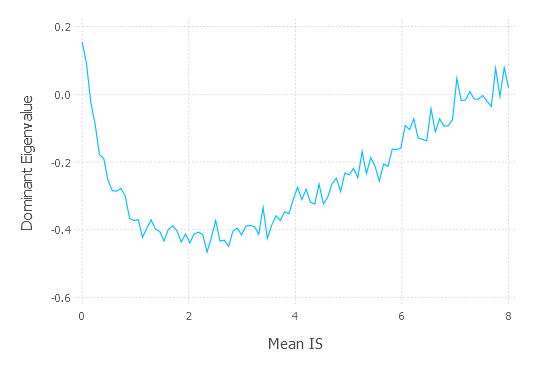

In [74]:
plot(x = samples[1][:, 1], y = mean_data, Geom.line, Guide.xlabel("Mean IS"), Guide.ylabel("Dominant Eigenvalue"))